In [1]:
import moscot
from moscot.problems.spatiotemporal import SpatioTemporalProblem

In [2]:
import scanpy as sc

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import moscot
from moscot.problems.generic import SinkhornProblem
import moscot.plotting as mpl
import pandas as pd
import os
import anndata as ad
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=200)
                         
import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)
plt.rcParams['legend.scatterpoints'] = 1 

['default', 'despine']


In [3]:
adata1 = ad.read_h5ad(
    "/lustre/groups/ml01/workspace/moscot_paper/alignment/E14-16h_a_count_normal_stereoseq.h5ad"
)
adata2 = ad.read_h5ad(
    "/lustre/groups/ml01/workspace/moscot_paper/alignment/E16-18h_a_count_normal_stereoseq.h5ad"
)
print(adata1.X.max(), adata2.X.max())
print(adata1.layers["raw_counts"].sum(), adata2.layers["raw_counts"].sum())
# ['0', '1', '2', '3', '4', '5', '6', '7']
# adata = adata[adata.obs.synth_batch == str(dataset["batch"])].copy()
# adata.X = rng.normal(size=adata.X.shape) + adata.X.copy()

7.0361485 5.212772
35190190.0 22735988.0


In [4]:
# get colors
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Access the Set3 colormap
set3 = plt.get_cmap('Set3')

# Generate 11 equally spaced intervals within the colormap
colors = set3(range(11))

# Convert each color from RGBA to hex format
hex_colors = [mcolors.rgb2hex(color) for color in colors]

# get keys
categories = set(adata1.obs["annotation"].cat.categories).union(set(adata2.obs["annotation"].cat.categories))
colors = {k:v for k,v in zip(categories, hex_colors)}

# for some reason matplotlib colormaps are different in every session so setting this here
colors = {'hemolymph': '#d9d9d9',
 'amnioserosa': '#ffffb3',
 'CNS': '#bebada',
 'salivary gland': '#fb8072',
 'foregut': '#80b1d3',
 'trachea': '#fdb462',
 'epidermis': '#b3de69',
 'midgut': '#fccde5',
 'muscle': '#8dd3c7',
 'fat body': '#bc80bd',
 'carcass': '#ccebc5'}

# add colors to anndata
adata1.uns["annotation_colors"] = [colors[i] for i in adata1.obs.annotation.cat.categories]
adata2.uns["annotation_colors"] = [colors[i] for i in adata2.obs.annotation.cat.categories]

sc.pp.highly_variable_genes(adata1, n_top_genes=8000)
sc.pp.highly_variable_genes(adata2, n_top_genes=8000)


In [5]:
genes1 = set(adata1.var_names[adata1.var.highly_variable].values)
genes2 = set(adata2.var_names[adata2.var.highly_variable].values)
genes = list(genes1.intersection(genes2))
len(genes)

5791

(29929, 5791)


/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


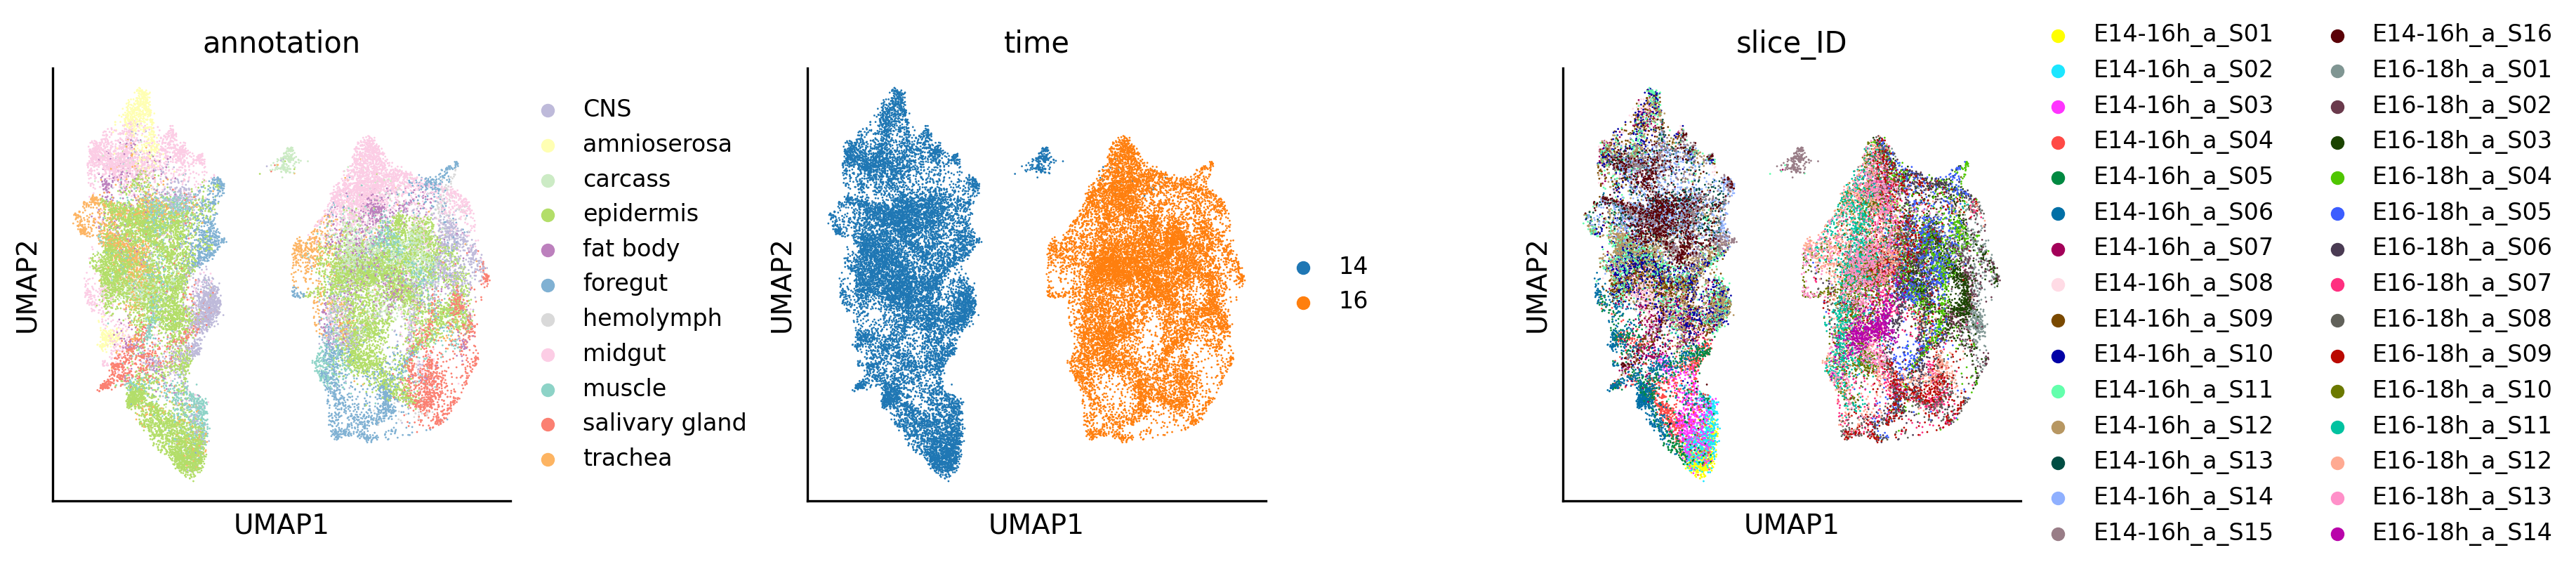

In [6]:
adata = ad.concat([adata1[:,genes], adata2[:,genes]], label="time", keys=[14, 16])
print(adata.shape)
sc.pp.pca(adata)
# sc.external.pp.scanorama_integrate(adata, "time")
# adata.obsm["X_umap_old"] = adata.obsm["X_umap"] 
# sc.pp.neighbors(adata, use_rep="X_scanorama")
# sc.tl.umap(adata)
adata.uns["annotation_colors"] = [colors[i] for i in adata.obs.annotation.cat.categories]

# sc.pp.neighbors(adata, use_rep="X_scanorama")
adata.obsm["X_umap_original"] = adata.obsm["X_umap"].copy()
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)

sc.pl.umap(adata, color=["annotation","time","slice_ID"], wspace=0.5)

In [7]:
ap = SpatioTemporalProblem(adata)
ap = ap.prepare(time_key="time", spatial_key="spatial", joint_attr={"attr":"obsm","key":"X_pca"})

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Normalizing spatial coordinates of `y`.                                                                   


In [8]:
from ott.solvers.linear import acceleration
ap = ap.solve(cost="cosine", alpha=0.3, epsilon=5e-2, threshold=1e-4, max_iterations=100, tau_a=0.990, tau_b=0.990, linear_solver_kwargs={"momentum":acceleration.Momentum(value=1., start=25)})

INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(15295, 14634)].                                


In [9]:
adata.obs["time"]

E14-16h_a_S01_20500x62780-0    14
E14-16h_a_S01_20500x62800-0    14
E14-16h_a_S01_20500x62820-0    14
E14-16h_a_S01_20500x62840-0    14
E14-16h_a_S01_20500x62860-0    14
                               ..
E16-18h_a_S14_47800x103760     16
E16-18h_a_S14_47800x103780     16
E16-18h_a_S14_47800x103800     16
E16-18h_a_S14_47800x103820     16
E16-18h_a_S14_47800x103840     16
Name: time, Length: 29929, dtype: category
Categories (2, int64): [14, 16]

In [10]:
# ap.compute_entropy(14, 16, batch_size=16)

In [11]:
# sc.pl.umap(tp0.adata, color=["conditional_entropy"])

In [12]:
import types
from typing import TYPE_CHECKING, Any, Dict, Literal, Mapping, Optional

import pandas as pd

from anndata import AnnData

from moscot import _constants
from moscot._types import ArrayLike, Str_Dict_t
from moscot.base.problems._mixins import AnalysisMixin, AnalysisMixinProtocol
from moscot.base.problems.compound_problem import B, K



def weighted_var(values, weights):
    """
    Return the weighted average and standard deviation.

    They weights are in effect first normalized so that they 
    sum to 1 (and so they must not all be 0).

    values, weights -- NumPy ndarrays with the same shape.
    """
    vars = []
    for i in range(len(weights)):
        w = weights[i] / np.sum(weights[i])
        
        # Calculate the weighted average
        average = np.average(values, weights=w, axis=0)
        
        # Calculate the weighted variance
        vars+=[np.average((values - average)**2, weights=w, axis=0)]
        
        
    return vars



def compute_cond_var(
    model,
    source: K,
    target: K,
    forward: bool = True,
    key_added: Optional[str] = "conditional_variance",
    batch_size: Optional[int] = None,
    attr: Dict[str, str] = {"attr": "obsm", "key": "X_pca"},
    **kwargs: Any,
) -> Optional[pd.DataFrame]:
    from statsmodels.stats.weightstats import DescrStatsW

    def _get_features(
            adata: AnnData,
            attr: Dict[str, Any] = {"attr": "obsm", "key": "X_pca"},
        ) -> ArrayLike:
            data = getattr(adata, attr["attr"])
            key = attr.get("key")
            if attr["attr"]=="X":
                return sc.get.obs_df(adata, keys=attr["key"], layer=None).values
            return data if key is None else data[key]

    filter_value = source if forward else target
    df = pd.DataFrame(
        index=model.adata[model.adata.obs[model._policy.key] == filter_value, :].obs_names,
        columns=[key_added] if key_added is not None else ["entropy"],
    )
    batch_size = batch_size if batch_size is not None else len(df)
    func = model.push if forward else model.pull
    tgt_features = _get_features(model[source, target].adata_tgt, attr)
    for batch in range(0, len(df), batch_size):
        cond_dists = func(
            source=source,
            target=target,
            data=None,
            subset=(batch, batch_size),
            normalize=True,
            return_all=False,
            scale_by_marginals=False,
            split_mass=True,
            key_added=None,
        )
        weighted_stats =weighted_var(tgt_features, cond_dists.T)
        df.iloc[range(batch, min(batch + batch_size, len(df))), 0] = np.mean(np.array(weighted_stats), axis=1)  # type: ignore[operator]
    if key_added is not None:
        model.adata.obs[key_added] = df
    return df if key_added is None else None

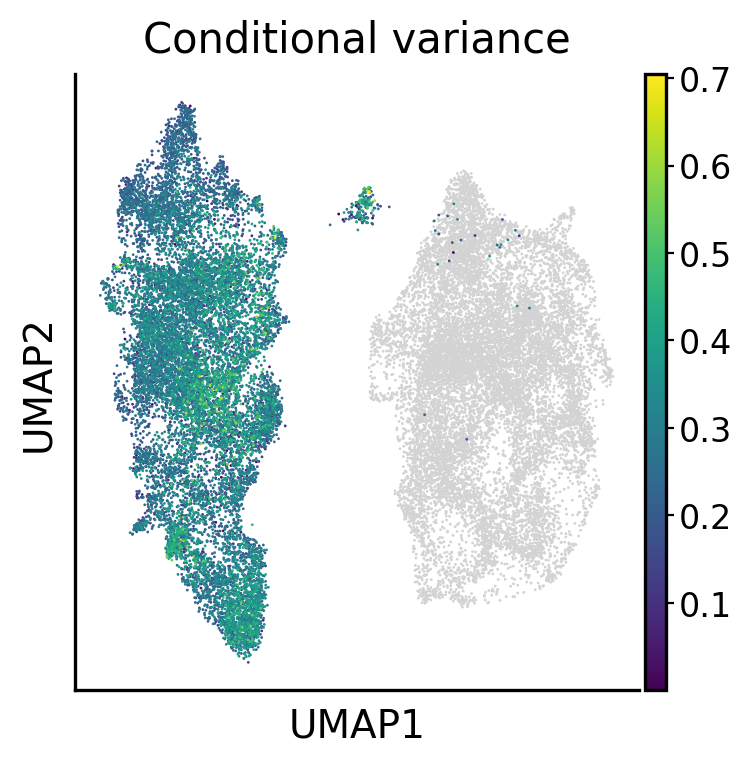

In [13]:
compute_cond_var(ap, 14, 16, batch_size=8)
sc.pl.umap(ap.adata, color=["conditional_variance"], title=f"Conditional variance")

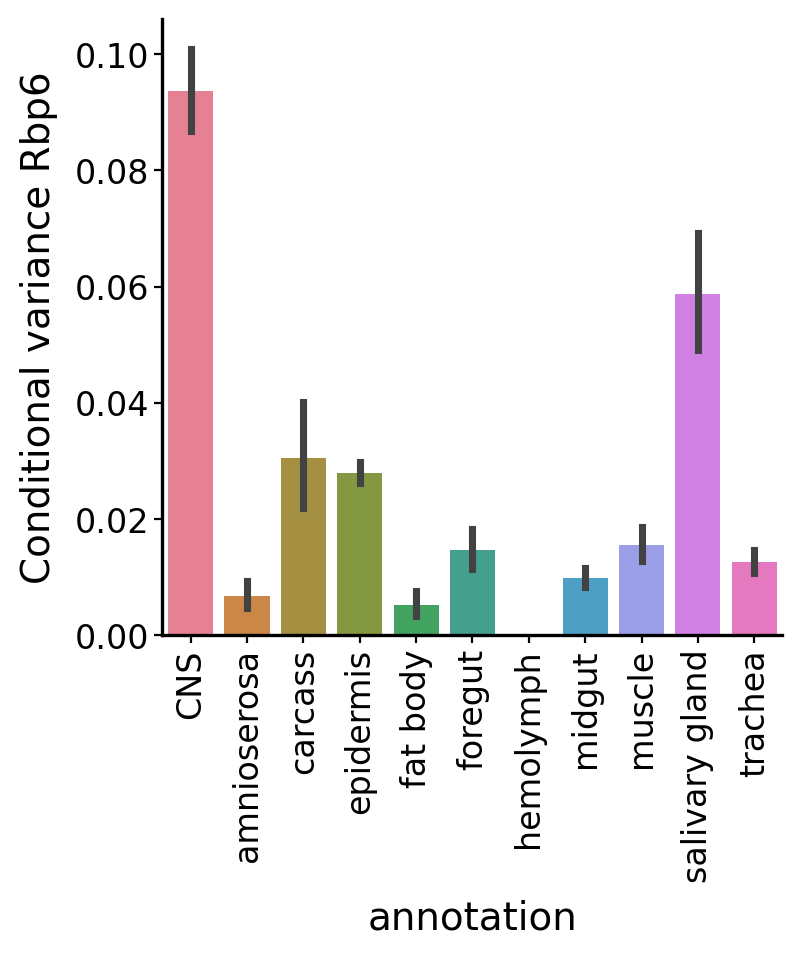

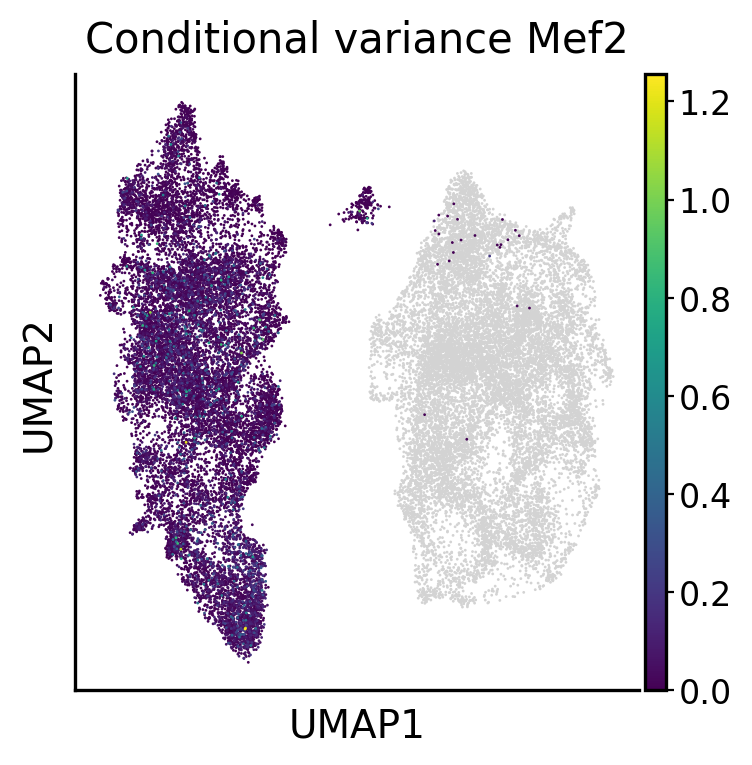

In [16]:
gene = "Mef2"
compute_cond_var(ap, 14, 16, batch_size=8, attr={"attr": "X", "key": [gene]})
sc.pl.umap(ap.adata, color=["conditional_variance"], title=f"Conditional variance {gene}")


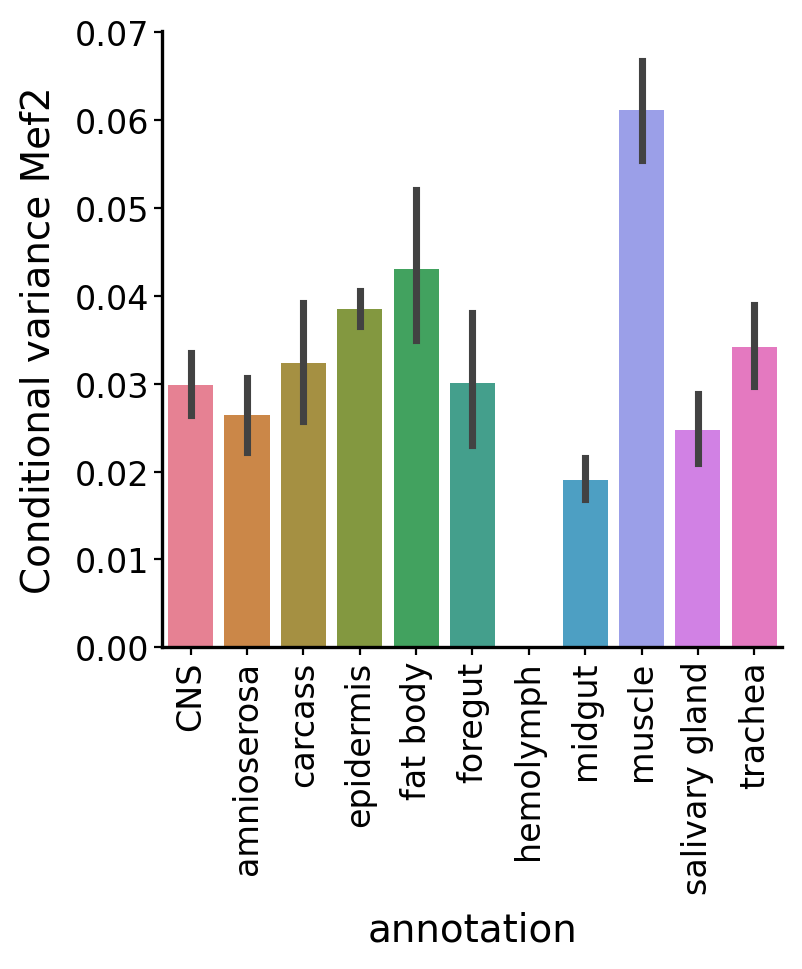

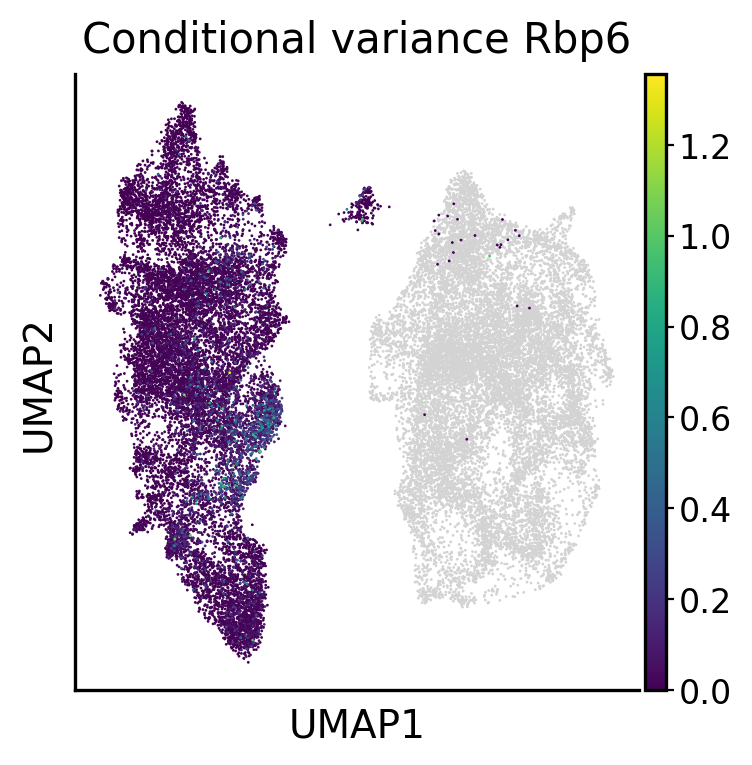

/tmp/ipykernel_1008579/3360625926.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_out.obs["annotation"] = pd.Categorical(adata_out.obs["annotation"])


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'CNS'),
  Text(1, 0, 'amnioserosa'),
  Text(2, 0, 'carcass'),
  Text(3, 0, 'epidermis'),
  Text(4, 0, 'fat body'),
  Text(5, 0, 'foregut'),
  Text(6, 0, 'hemolymph'),
  Text(7, 0, 'midgut'),
  Text(8, 0, 'muscle'),
  Text(9, 0, 'salivary gland'),
  Text(10, 0, 'trachea')])

In [15]:
gene = "Rbp6"
compute_cond_var(ap, 14, 16, batch_size=8, attr={"attr": "X", "key": [gene]})
sc.pl.umap(ap.adata, color=["conditional_variance"], title=f"Conditional variance {gene}")
adata_out = ap.adata[ap.adata.obs["time"].isin((14,16))]
adata_out.obs["annotation"] = pd.Categorical(adata_out.obs["annotation"])
g = sns.barplot(adata_out.obs, y="conditional_variance", x="annotation", hue="annotation")
g.set_ylabel(f"Conditional variance {gene}")
plt.xticks(rotation=90)

In [ ]:
sc.pl.umap(ap.adata, color=["conditional_variance"], title=f"Conditional variance {gene}")


In [17]:
adata_out = ap.adata[ap.adata.obs["time"].isin((14,16))]
adata_out.obs["annotation"] = pd.Categorical(adata_out.obs["annotation"])
g = sns.barplot(adata_out.obs, y="conditional_variance", x="annotation", hue="annotation")
g.set_ylabel(f"Conditional variance {gene}")
plt.xticks(rotation=90)

/tmp/ipykernel_1008579/2337562697.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_out.obs["annotation"] = pd.Categorical(adata_out.obs["annotation"])


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'CNS'),
  Text(1, 0, 'amnioserosa'),
  Text(2, 0, 'carcass'),
  Text(3, 0, 'epidermis'),
  Text(4, 0, 'fat body'),
  Text(5, 0, 'foregut'),
  Text(6, 0, 'hemolymph'),
  Text(7, 0, 'midgut'),
  Text(8, 0, 'muscle'),
  Text(9, 0, 'salivary gland'),
  Text(10, 0, 'trachea')])

In [18]:
compute_cond_var(ap, 14, 16, batch_size=8)
adata_out = ap.adata[ap.adata.obs["time"].isin((14,16))]

In [19]:
adata_out.obs

,slice_ID,raw_x,raw_y,new_x,new_y,new_z,annotation,time,conditional_variance
E14-16h_a_S01_20500x62780-0,E14-16h_a_S01,20500,62780,-11.170124,-8.070539,1.0,CNS,14,0.397836
E14-16h_a_S01_20500x62800-0,E14-16h_a_S01,20500,62800,-11.170124,-7.070539,1.0,CNS,14,0.349156
E14-16h_a_S01_20500x62820-0,E14-16h_a_S01,20500,62820,-11.170124,-6.070539,1.0,epidermis,14,0.418709
E14-16h_a_S01_20500x62840-0,E14-16h_a_S01,20500,62840,-11.170124,-5.070539,1.0,CNS,14,0.338966
E14-16h_a_S01_20500x62860-0,E14-16h_a_S01,20500,62860,-11.170124,-4.070539,1.0,CNS,14,0.382271
...,...,...,...,...,...,...,...,...,...
E16-18h_a_S14_47800x103760,E16-18h_a_S14,47800,103760,5.778575,10.286161,9.1,fat body,16,NaN
E16-18h_a_S14_47800x103780,E16-18h_a_S14,47800,103780,6.692203,9.879609,9.1,trachea,16,NaN
E16-18h_a_S14_47800x103800,E16-18h_a_S14,47800,103800,7.605830,9.473058,9.1,midgut,16,NaN
E16-18h_a_S14_47800x103820,E16-18h_a_S14,47800,103820,8.519458,9.066506,9.1,carcass,16,NaN


In [20]:
%matplotlib inline
adata_out.obs["annotation"] = pd.Categorical(adata_out.obs["annotation"])
g = sns.barplot(adata_out.obs, y="conditional_variance", x="annotation", hue="annotation")
g.set_ylabel("Conditional variance PCA")
plt.xticks(rotation=90)

/tmp/ipykernel_1008579/3817375631.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_out.obs["annotation"] = pd.Categorical(adata_out.obs["annotation"])


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'CNS'),
  Text(1, 0, 'amnioserosa'),
  Text(2, 0, 'carcass'),
  Text(3, 0, 'epidermis'),
  Text(4, 0, 'fat body'),
  Text(5, 0, 'foregut'),
  Text(6, 0, 'hemolymph'),
  Text(7, 0, 'midgut'),
  Text(8, 0, 'muscle'),
  Text(9, 0, 'salivary gland'),
  Text(10, 0, 'trachea')])

In [22]:
sc.pp.neighbors(adata, use_rep="X_pca")

In [23]:
df_dists = pd.DataFrame(index=adata.obs["cell_type"].unique(), columns=["mean_dist"])

In [24]:
from sklearn.metrics.pairwise import pairwise_distances

for ct in adata.obs["cell_type"].unique():
    data = adata[adata.obs["cell_type"]==ct].obsm["X_pca"]
    dist = pairwise_distances(data).mean()
    df_dists.loc[ct, "mean_dist"] = dist

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

In [25]:
df_dists

,mean_dist
Alpha,10.535953
Fev+,10.093472
Eps. progenitors,8.849004
Ngn3 high,11.203861
Ngn3 low,9.940623
Fev+ Beta,10.120769
Fev+ Alpha,9.969649
Ngn3 high cycling,11.622095
Fev+ Delta,11.355751
Epsilon,12.113378


In [26]:
adata.obs["dist_knn"] = adata.obsp["distances"].mean(axis=1)

In [27]:
df= adata.obs[["dist_knn", "cell_type"]].groupby("cell_type").mean().sort_values(by="dist_knn")

/tmp/ipykernel_3908565/3953337842.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df= adata.obs[["dist_knn", "cell_type"]].groupby("cell_type").mean().sort_values(by="dist_knn")


In [28]:
df["conditional_entropy"] = adata.obs[["conditional_entropy", "cell_type"]].groupby("cell_type").mean().sort_values(by="conditional_entropy")

/tmp/ipykernel_3908565/1132976959.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["conditional_entropy"] = adata.obs[["conditional_entropy", "cell_type"]].groupby("cell_type").mean().sort_values(by="conditional_entropy")


In [29]:
df["conditional_variance"] = adata.obs[["conditional_variance", "cell_type"]].groupby("cell_type").mean().sort_values(by="conditional_variance")

/tmp/ipykernel_3908565/2870501658.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["conditional_variance"] = adata.obs[["conditional_variance", "cell_type"]].groupby("cell_type").mean().sort_values(by="conditional_variance")


In [30]:
df

,dist_knn,conditional_entropy,conditional_variance
cell_type,,,
Ngn3 low,0.007532,5.585359,0.766975
Ngn3 high,0.007788,5.60016,0.941636
Eps. progenitors,0.007986,4.688085,0.887635
Beta,0.008129,4.990887,0.340375
Fev+ Beta,0.008798,5.440908,0.797064
Fev+,0.008992,5.522676,1.324904
Fev+ Delta,0.009086,4.911909,1.008085
Alpha,0.009329,5.345271,1.217802
Fev+ Alpha,0.009461,5.352817,1.444023


In [31]:
from scipy.stats import spearmanr
spearman_corr = pd.DataFrame(index=df.columns, columns=df.columns)

# Calculate Spearman correlation for each pair of columns
for col1 in df.columns:
    for col2 in df.columns:
        if col1 == col2:
            spearman_corr.loc[col1, col2] = 1.0  # The correlation with itself is 1
        else:
            corr, _ = spearmanr(df[col1], df[col2])
            spearman_corr.loc[col1, col2] = corr

In [32]:
spearman_corr

,dist_knn,conditional_entropy,conditional_variance
dist_knn,1.0,-0.552448,0.447552
conditional_entropy,-0.552448,1.0,0.090909
conditional_variance,0.447552,0.090909,1.0
